All the import statements in one cell.

In [73]:
import json
import pickle
import gc
import glob
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import dask.bag as db
import dask.distributed

from hist import Hist

Use all my cores, even though what I want to do is pure Python. (Dask Bag!)

In [2]:
client = dask.distributed.Client(n_workers=16, threads_per_worker=1)
client

2023-04-15 14:51:33,366 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_4ua17js', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 62.10 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37749,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 62.10 GiB
Comm: tcp://127.0.0.1:46361,Total threads: 1
Dashboard: http://127.0.0.1:34703/status,Memory: 3.88 GiB
Nanny: tcp://127.0.0.1:37379,


Only need to do this if `/tmp/*` is out of date, not every time the notebook gets relaunched.

In [33]:
cmssw_file_ages = list(json.load(open("/home/jpivarski/storage/data/physicists/forks-of-cmssw-2023-02-13/file-ages.json")).items())

In [40]:
len(cmssw_file_ages)

22961

In [34]:
start = stop = 0
for i in range(100):
    stop = min(stop + int(np.ceil(len(cmssw_file_ages) / 100)), len(cmssw_file_ages))
    pickle.dump(dict(cmssw_file_ages[start:stop]), open(f"/tmp/cmssw-file-ages-{i}.pkl", "wb"))
    start = stop

In [35]:
root_file_ages = list(json.load(open("/home/jpivarski/storage/data/physicists/github-archive/file-ages.json")).items())

In [41]:
len(root_file_ages)

17334

In [36]:
start = stop = 0
for i in range(100):
    stop = min(stop + int(np.ceil(len(root_file_ages) / 100)), len(root_file_ages))
    pickle.dump(dict(root_file_ages[start:stop]), open(f"/tmp/root-file-ages-{i}.pkl", "wb"))
    start = stop

Start if if relaunching the notebook.

In [37]:
cmssw_file_ages_names = db.from_sequence([f"/tmp/cmssw-file-ages-{i}.pkl" for i in range(100)])
root_file_ages_names = db.from_sequence([f"/tmp/root-file-ages-{i}.pkl" for i in range(100)])

## Question 1

Some repos are clearly copy-pasted, like private copies of CMSSW. Do we see that as a spike of many files with nearly identical ages?

In [4]:
def calculate_num_files_std_age(filename):
    gc.disable()
    batch = pickle.load(open(filename, "rb"))
    out = {}
    for name, repo in batch.items():
        ages = []
        for file, data in repo.items():
            try:
                ages.append(datetime.strptime(data[0], "%Y-%m-%d %H:%M:%S %z").timestamp()/60/60/24)
            except ValueError:
                pass
        out[name] = {"num_files": len(ages), "std_age": np.std(ages) if len(ages) != 0 else 0.0}
    return out

In [5]:
num_files_std_age = cmssw_file_ages_names.map(calculate_num_files_std_age)

In [6]:
num_files_std_age = num_files_std_age.compute()

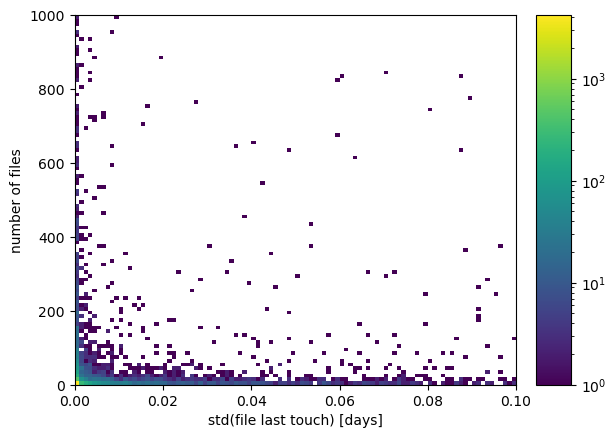

In [21]:
fig, ax = plt.subplots(1, 1)

Hist.new.Reg(100, 0, 0.1, name="std(file last touch) [days]").Reg(100, 0, 1000, name="number of files").Double().fill(
    [data["std_age"] for batch in num_files_std_age for name, data in batch.items()],
    [data["num_files"] for batch in num_files_std_age for name, data in batch.items()],
).plot(ax=ax, norm=matplotlib.colors.LogNorm());

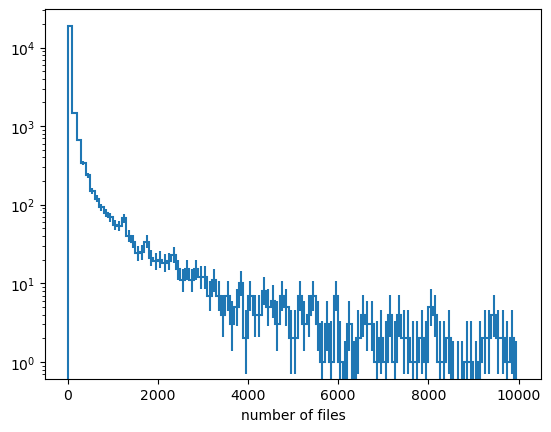

In [52]:
fig, ax = plt.subplots(1, 1)

Hist.new.Reg(100, 0, 10000, name="number of files").Double().fill(
    [data["num_files"] for batch in num_files_std_age for name, data in batch.items()],
).plot(ax=ax);

ax.set_yscale("log");

In [67]:
num_files_std_age = root_file_ages_names.map(calculate_num_files_std_age)

In [68]:
num_files_std_age = num_files_std_age.compute()

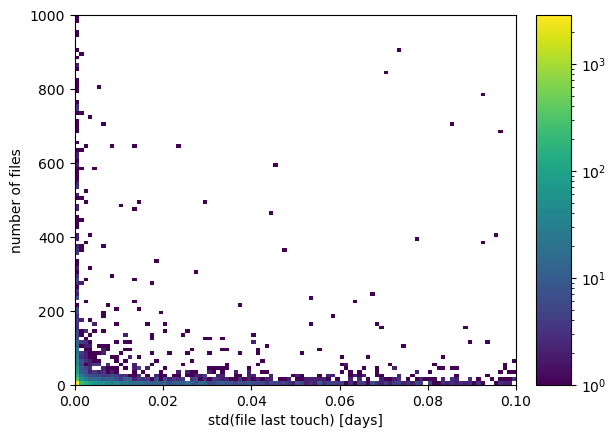

In [69]:
fig, ax = plt.subplots(1, 1)

Hist.new.Reg(100, 0, 0.1, name="std(file last touch) [days]").Reg(100, 0, 1000, name="number of files").Double().fill(
    [data["std_age"] for batch in num_files_std_age for name, data in batch.items()],
    [data["num_files"] for batch in num_files_std_age for name, data in batch.items()],
).plot(ax=ax, norm=matplotlib.colors.LogNorm());

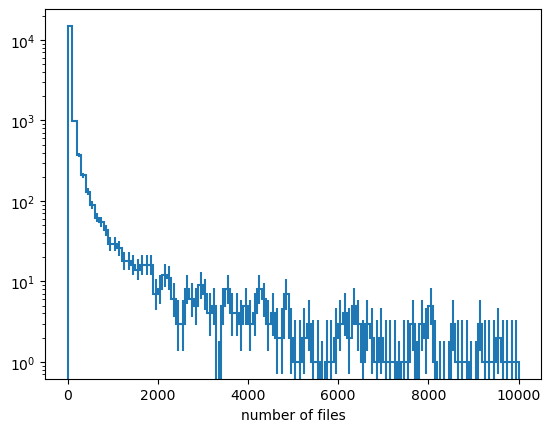

In [71]:
fig, ax = plt.subplots(1, 1)

Hist.new.Reg(100, 0, 10000, name="number of files").Double().fill(
    [data["num_files"] for batch in num_files_std_age for name, data in batch.items()],
).plot(ax=ax);

ax.set_yscale("log");

In [27]:
extremes = [[name, data["num_files"]] for batch in num_files_std_age for name, data in batch.items() if data["num_files"] > 100]
extremes.sort(key=lambda x: x[1])
extremes[-10:]

[['jsiado/Wprime', 95746],
 ['mpresill/VBS_unitarity', 96324],
 ['AnYpku/PKU-Cluster', 109450],
 ['hbprosper/CI8TeV', 111691],
 ['emcannaert/FNALLPC', 128210],
 ['sciencecw/AI4code_Erdos_2022', 140678],
 ['cmstas/DataTuple-backup', 163192],
 ['hrishikeshgoyal/NetBSD-kernel-source', 175535],
 ['tvami/HSCPbackgroundPred', 196789],
 ['mialiu149/fpixphase1', 314795]]

**Answer to question 1:** After looking at these repos, they also copied some of the git history, so that's why we don't see a lot of files with the same age.

They do need to be cut out somehow, though. Maybe just number of files.

In [53]:
def calculate_repos_with_few_files(filename):
    gc.disable()
    batch = pickle.load(open(filename, "rb"))
    out = 0
    for name, repo in batch.items():
        if len(repo) < 1000:
            out += 1
    return out

In [54]:
cmssw_file_ages_names.map(calculate_repos_with_few_files).sum().compute() / 22961

0.958364182744654

In [55]:
root_file_ages_names.map(calculate_repos_with_few_files).sum().compute() / 17334

0.9700588438906196

In [65]:
def calculate_names_of_repos_with_few_files(filename):
    gc.disable()
    batch = pickle.load(open(filename, "rb"))
    out = []
    for name, repo in batch.items():
        if len(repo) < 10000:
            out.append([name, len(repo)])
    out.sort(key=lambda x: x[1])
    return out[-1]   # show the most borderline cases

In [66]:
sorted(cmssw_file_ages_names.map(calculate_names_of_repos_with_few_files).compute(), key=lambda x: x[1])[-10:]

[['waredjeb/graviton-analysis', 9454],
 ['scooperstein/CMSSW_5_3_3', 9462],
 ['choij1589/ChargedHiggsAnalysis', 9497],
 ['rappoccio/usercode', 9503],
 ['mobassirameen/BsPi-Analysis', 9578],
 ['FHead/PhysicsEEJet', 9603],
 ['lsoffi/SherpaHggInterference', 9640],
 ['ramankhurana/HGCALTBAnalysis', 9760],
 ['cranelli/GenProductions', 9805],
 ['SiewYan/Genprod2', 9840]]

In [72]:
sorted(root_file_ages_names.map(calculate_names_of_repos_with_few_files).compute(), key=lambda x: x[1])[-10:]

[['LucaZampieri/myDotfiles', 9131],
 ['ViralTaco/Exercism-Solutions', 9164],
 ['parikshit223933/Kaggle', 9207],
 ['davidwed/cegcc-gcc', 9309],
 ['xywei/dealii-docset', 9557],
 ['philr1976/limbo-android', 9570],
 ['andriish/rivet', 9636],
 ['redeboer/BOSS_ExternalLibs', 9778],
 ['Alessandro-Barbieri/node-overlay', 9850],
 ['Aniq55/DSS_src', 9978]]

## Cut against fake forks

For repos bigger than 10000 (top 10% or so), we get the list of all contributors. For these big repos, we want to exclude repos in which the owner did not contribute the most commits.

In [124]:
cmssw_repo_fraction_commits = {}
for filename in glob.glob("/home/jpivarski/storage/data/physicists/forks-of-cmssw-2023-02-13/user-repos-contributors/*.json"):
    reponame = filename[90:-5].replace("__", "/")
    if reponame == "Abdoelabassi/Quantum/qiskit/Starter":
        reponame = "Abdoelabassi/Quantum__qiskit__Starter"
    assert reponame.count("/") == 1, reponame
    owner = reponame[:reponame.index("/")]
    filedata = open(filename).read()
    if len(filedata.strip()) == 0:
        cmssw_repo_fraction_commits[reponame] = 0.0
    else:
        contributors = json.loads(filedata)
        if isinstance(contributors, dict) and contributors["message"] in ("Moved Permanently", "Not Found", "Repository access blocked"):
            cmssw_repo_fraction_commits[reponame] = 0.0
        else:
            total_commits = sum(x["contributions"] for x in contributors)
            if total_commits == 0:
                cmssw_repo_fraction_commits[reponame] = 1.0
            else:
                cmssw_repo_fraction_commits[reponame] = sum(x["contributions"] for x in contributors if x["login"] == owner) / total_commits

In [125]:
root_repo_fraction_commits = {}
for filename in glob.glob("/home/jpivarski/storage/data/physicists/github-archive/root-repo-user-repos-contributors/*.json"):
    reponame = filename[89:-5].replace("__", "/")
    assert reponame.count("/") == 1, reponame
    owner = reponame[:reponame.index("/")]
    contributors = json.load(open(filename))
    if isinstance(contributors, dict) and contributors["message"] in ("The history or contributor list is too large to list contributors for this repository via the API.", "Not Found", "Repository access blocked"):
        root_repo_fraction_commits[reponame] = 0.0
    else:
        total_commits = sum(x["contributions"] for x in contributors)
        if total_commits == 0:
            root_repo_fraction_commits[reponame] = 1.0
        else:
            root_repo_fraction_commits[reponame] = sum(x["contributions"] for x in contributors if x["login"] == owner) / total_commits

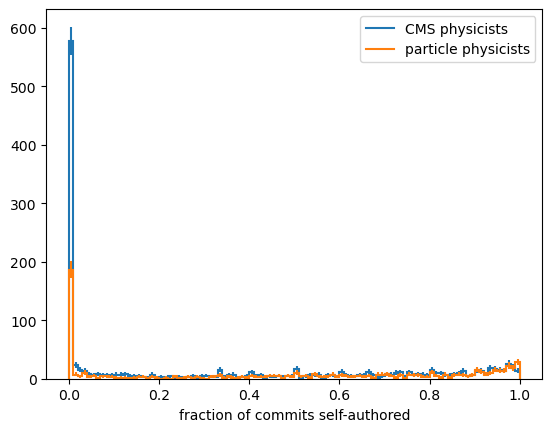

In [129]:
fig, ax = plt.subplots(1, 1)

Hist.new.Reg(100, 0, 1, name="fraction of commits self-authored").Double().fill(
    list(cmssw_repo_fraction_commits.values())
).plot(ax=ax)

Hist.new.Reg(100, 0, 1, name="fraction of commits self-authored").Double().fill(
    list(root_repo_fraction_commits.values())
).plot(ax=ax)

ax.legend(["CMS physicists", "particle physicists"]);

In [136]:
cmssw_repo_exclude = {name for name, fraction in cmssw_repo_fraction_commits.items() if fraction < 0.01}
root_repo_exclude = {name for name, fraction in root_repo_fraction_commits.items() if fraction < 0.01}

In [137]:
len(cmssw_repo_exclude), len(root_repo_exclude)

(577, 186)

This will be easy: **exclude** any repos bigger than 10000 (GitHub's estimation; only the top 10%) for which fewer than 1% of the commits are self-authored.

It's not very many, but it probably represents a lot of files. Now I can make plots that scale with the number of files.

Names of those repos (revealing that this also catches org accounts):

In [138]:
cmssw_repo_exclude

{'4quarks/usercode',
 'AdrianAlan/L1Trigger_VAE',
 'AlbertHsuNTUphys/ChargeFlipStudy',
 'AlbertHsuNTUphys/Hello-word',
 'Alex2671/drivemenu.github.io',
 'AlexandreMertens/WingTsunNamur',
 'AlexandreMertens/website',
 'AlexandreMertens/wingtsunwallonie',
 'AnYpku/cmssw10x',
 'AndreasAlbert/genprod2',
 'AndreasAlbert/genprodCards',
 'Axel-Naumann/clang',
 'Axel-Naumann/llvm',
 'BParkHNLs/HNLsGen',
 'BaylorCMS/HCALTB2015',
 'BaylorCMS/HcalPromptAnalysis',
 'BaylorCMS/HcalRelVal',
 'BetterWang/g4e',
 'CERN-PH-CMG/cmg-cmssw',
 'CERN-PH-CMG/cmgtools-lite',
 'CJLST/ZZAnalysis',
 'CMS-HGCAL/TestBeam',
 'CMS-HGCAL/reco-ntuples',
 'CMS-HIN-dilepton/DimuonCADIs',
 'CMS-HIN-dilepton/Dimuons',
 'CMS-HTT/2015-sync',
 'CMS-HTT/CorrectionsWorkspace',
 'CMS-LUMI-POG/BeamImaging',
 'CMS-LUMI-POG/PCCTools',
 'CMS-LUMI-POG/VdMFramework',
 'CMS-LUMI-POG/ZCounting',
 'CMSDIJET/DarkMatterInterpretation',
 'CMSDIJET/DijetLimitCode',
 'CMSDIJET/DijetRootTreeAnalyzer',
 'CMSDIJET/DijetShapeInterpolator',
 'CMSL

In [139]:
root_repo_exclude

{'38tter/haniwa-dogu-recognition',
 'AaronBallman/tra-working',
 'AlejandroJL/mp4parser',
 'AnYpku/cmssw10x',
 'Axel-Naumann/clang',
 'Axel-Naumann/llvm',
 'ChristopherRabotin/GMAT',
 'Daniel-Dane/DetectorCourse_CanDetector',
 'Eideticom/docker-noload',
 'Eideticom/eid-hermes-qemu',
 'ElsevierSoftwareX/PyScratch',
 'ElsevierSoftwareX/SOFTX-D-15-00003',
 'JarlPed/ase',
 'Joonpark13/structify',
 'LSchwiebert/GOMC_GPU',
 'LeCastorFou/PARCweb',
 'LucasReSilva/MeuPrimeiroAppSwift',
 'Noflare/wavvy-medusa',
 'PetrilloAtWork/dunetpc',
 'RTSYork/BlueIO',
 'RTSYork/MrsP_Implementation_Litmus',
 'RTSYork/RTSScreen',
 'RTSYork/Real-Time-Stream-Processing',
 'RTSYork/airtight',
 'RTSYork/linux-4.1.15-rt17-profiling',
 'Teemperor/cif',
 'Teemperor/clang-dump',
 'UWCNuclear/Geant4Scintillator',
 'VRanger/FastHub',
 'VRanger/LH_Kernel',
 'VRanger/dragontc-7.0',
 'VRanger/quantum',
 'aannabe/accurate_energies',
 'aannabe/chk_files',
 'aannabe/diamond_si',
 'aannabe/si_molecules',
 'aarongrisez/Mantico

## Question 2

Fraction of 